# VIGIA Competition Notebook

This notebook is a conversion of the `vigia-competition.py` script. Each section of the original script is split into one or more cells.

Description: This notebook converts the vigia script into a multi-cell Jupyter Notebook for the VIGIA Competition.

In [29]:
# Description: Import necessary libraries including pandas, numpy, tensorflow, and additional modules.
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split  # CV splitter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [30]:
# Description: Set CNN hyperparameters and file paths.
IMG_SIZE     = (32, 32)        # input resolution in your CNN
BATCH_SIZE   = 64
EPOCHS       = 15
N_SPLITS     = 5               # k-fold
SEED         = 42

TRAIN_DIR    = "archive/train/train/"   # path with labelled jpg
TEST_DIR     = "archive/train/train/"     # modified: use training directory since no true test labels
TRAIN_CSV    = "archive/train.csv"


In [21]:
# Description: Load training data from CSV and split it into cross-validation and hold-out test sets.
train_df = pd.read_csv(TRAIN_CSV)
print("Training samples:", len(train_df))

# Split the full training set into CV and hold-out test sets (both from TRAIN_DIR)
train_cv_df, holdout_df = train_test_split(train_df, test_size=0.2, stratify=train_df['has_cactus'], random_state=SEED)
print("Train CV samples:", len(train_cv_df))
print("Holdout Test samples:", len(holdout_df))

Training samples: 17500
Train CV samples: 14000
Holdout Test samples: 3500


## Helper: Build a Fresh Model for Each Fold

The following function creates a new CNN model to be used in every fold of cross validation.

Description: This section describes a helper function used to construct the CNN model.

In [31]:
# Updated: Configurable CNN model builder
def build_model(kernel_size=(3,3), stride=(1,1), padding='valid', num_conv_layers=2):
    import tensorflow as tf
    model = tf.keras.Sequential()
    for i in range(num_conv_layers):
        filters = 32 * (2 ** i)
        if i == 0:
            model.add(tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu', input_shape=IMG_SIZE + (3,)))
        else:
            model.add(tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Contoh penggunaan dengan hyperparameter custom
# model = build_model(kernel_size=(5,5), stride=(1,1), padding='same', num_conv_layers=3)
# ...existing code...

## Cross-Validation Loop

The following cell performs k-fold cross validation. For each fold, it splits the data, creates data generators, builds & trains the model, and makes predictions on the test set.

Description: This section implements the k-fold cross-validation loop.

In [32]:
# Description: Perform k-fold cross-validation with data generation, training, and validation.
# Define data generators for training and validation
tr_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Use the train_cv_df for k-fold cross validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# Use the train_cv_df for k-fold cross validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
histories = []
val_scores = []
test_pred_table = []  # will store predictions on the validation fold per CV

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_cv_df['id'], train_cv_df['has_cactus'])):
    print(f"\n──────────  Fold {fold+1}/{N_SPLITS}  ──────────")
    tr_fold_df  = train_cv_df.iloc[tr_idx].reset_index(drop=True)
    val_fold_df = train_cv_df.iloc[val_idx].reset_index(drop=True)

    # Convert target column to string for binary classification if needed
    tr_fold_df['has_cactus'] = tr_fold_df['has_cactus'].astype(str)
    val_fold_df['has_cactus'] = val_fold_df['has_cactus'].astype(str)

    tr_gen = tr_datagen.flow_from_dataframe(
        tr_fold_df, TRAIN_DIR,
        x_col='id', y_col='has_cactus',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='binary', shuffle=True, seed=SEED
    )
    val_gen = val_datagen.flow_from_dataframe(
        val_fold_df, TRAIN_DIR,
        x_col='id', y_col='has_cactus',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='binary', shuffle=False
    )

    model = build_model()
    es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    hist = model.fit(
        tr_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[es],
        verbose=1
    )
    histories.append(hist)
    val_acc = hist.history['val_accuracy'][-1]
    val_scores.append(val_acc)
    print(f"Fold-{fold+1} final val-accuracy: {val_acc:.4f}")
    test_pred_table.append(hist.history['val_accuracy'][-1])


──────────  Fold 1/5  ──────────
Found 11200 validated image filenames belonging to 2 classes.
Found 2800 validated image filenames belonging to 2 classes.
Found 2800 validated image filenames belonging to 2 classes.
Epoch 1/15
Epoch 1/15


/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8255 - loss: 0.3722 - val_accuracy: 0.9443 - val_loss: 0.1415
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8255 - loss: 0.3722 - val_accuracy: 0.9443 - val_loss: 0.1415
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9464 - loss: 0.1539 - val_accuracy: 0.9611 - val_loss: 0.1108
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9464 - loss: 0.1539 - val_accuracy: 0.9611 - val_loss: 0.1108
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9516 - loss: 0.1326 - val_accuracy: 0.9596 - val_loss: 0.1129
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9516 - loss: 0.1326 - val_accuracy: 0.9596 - val_loss: 0.1129
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9571 - loss: 0.1208 - val_accuracy: 0.9579 - val_loss: 0.1014
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9571 - loss: 0.1208 - val_accuracy: 0.957

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8234 - loss: 0.3684 - val_accuracy: 0.9457 - val_loss: 0.1508
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8234 - loss: 0.3684 - val_accuracy: 0.9457 - val_loss: 0.1508
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9427 - loss: 0.1697 - val_accuracy: 0.9568 - val_loss: 0.1165
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9427 - loss: 0.1697 - val_accuracy: 0.9568 - val_loss: 0.1165
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9454 - loss: 0.1477 - val_accuracy: 0.9636 - val_loss: 0.1005
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9454 - loss: 0.1477 - val_accuracy: 0.9636 - val_loss: 0.1005
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9485 - loss: 0.1468 - val_accuracy: 0.9686 - val_loss: 0.0982
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9485 - loss: 0.1468 - val_accuracy: 0.968

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8106 - loss: 0.3791 - val_accuracy: 0.9446 - val_loss: 0.1532
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8106 - loss: 0.3791 - val_accuracy: 0.9446 - val_loss: 0.1532
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9413 - loss: 0.1654 - val_accuracy: 0.9625 - val_loss: 0.1052
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9413 - loss: 0.1654 - val_accuracy: 0.9625 - val_loss: 0.1052
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9544 - loss: 0.1258 - val_accuracy: 0.9536 - val_loss: 0.1298
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9544 - loss: 0.1258 - val_accuracy: 0.9536 - val_loss: 0.1298
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9617 - loss: 0.1164 - val_accuracy: 0.9639 - val_loss: 0.1042
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9617 - loss: 0.1164 - val_accuracy: 0.963

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8403 - loss: 0.3432 - val_accuracy: 0.9443 - val_loss: 0.1575
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8403 - loss: 0.3432 - val_accuracy: 0.9443 - val_loss: 0.1575
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9383 - loss: 0.1592 - val_accuracy: 0.9354 - val_loss: 0.1917
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9383 - loss: 0.1592 - val_accuracy: 0.9354 - val_loss: 0.1917
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9514 - loss: 0.1383 - val_accuracy: 0.9600 - val_loss: 0.1096
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9514 - loss: 0.1383 - val_accuracy: 0.9600 - val_loss: 0.1096
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9572 - loss: 0.1141 - val_accuracy: 0.9646 - val_loss: 0.1025
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9572 - loss: 0.1141 - val_accuracy: 0.964

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8045 - loss: 0.4170 - val_accuracy: 0.9171 - val_loss: 0.2359
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8045 - loss: 0.4170 - val_accuracy: 0.9171 - val_loss: 0.2359
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9286 - loss: 0.1957 - val_accuracy: 0.9350 - val_loss: 0.1861
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9286 - loss: 0.1957 - val_accuracy: 0.9350 - val_loss: 0.1861
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9471 - loss: 0.1552 - val_accuracy: 0.9554 - val_loss: 0.1217
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9471 - loss: 0.1552 - val_accuracy: 0.9554 - val_loss: 0.1217
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9517 - loss: 0.1425 - val_accuracy: 0.9671 - val_loss: 0.1012
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9517 - loss: 0.1425 - val_accuracy: 0.967

In [24]:
# Description: Setup hold-out test set generator and evaluate the final model on it.
# Create a generator for the hold-out test set from the same TRAIN_DIR
holdout_df['has_cactus'] = holdout_df['has_cactus'].astype(str)
holdout_gen = val_datagen.flow_from_dataframe(
    dataframe=holdout_df,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='has_cactus',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Evaluate the final model on the hold-out test set (using the last model trained in CV, for example)
holdout_eval = model.evaluate(holdout_gen, verbose=1)
print("Holdout Test Loss/Accuracy:", holdout_eval)

Found 3500 validated image filenames belonging to 2 classes.
 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9681 - loss: 0.0594

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9801 - loss: 0.0500
Holdout Test Loss/Accuracy: [0.05298978090286255, 0.9802857041358948]
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9801 - loss: 0.0500
Holdout Test Loss/Accuracy: [0.05298978090286255, 0.9802857041358948]


In [25]:
# Description: Display CV accuracy per fold, ensemble predictions, and create a submission file.
print("\nCV accuracy per fold:", np.round(val_scores, 4))
print(f"Mean ± SD accuracy  : {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

# Ensemble (mean) of probabilities from all folds
test_mean_prob = np.mean(np.stack(test_pred_table, axis=0), axis=0)
test_labels    = (test_mean_prob > 0.5).astype(int)

submission = pd.DataFrame({
    "id": [Path(p).name for p in sorted(Path(TEST_DIR).glob("*.jpg"))],
    "has_cactus": test_labels
})
submission.to_csv("submission_kfold.csv", index=False)
print("✔ submission_kfold.csv saved")


CV accuracy per fold: [0.9779 0.9636 0.9814 0.9825 0.9775]
Mean ± SD accuracy  : 0.9766 ± 0.0068
✔ submission_kfold.csv saved
✔ submission_kfold.csv saved


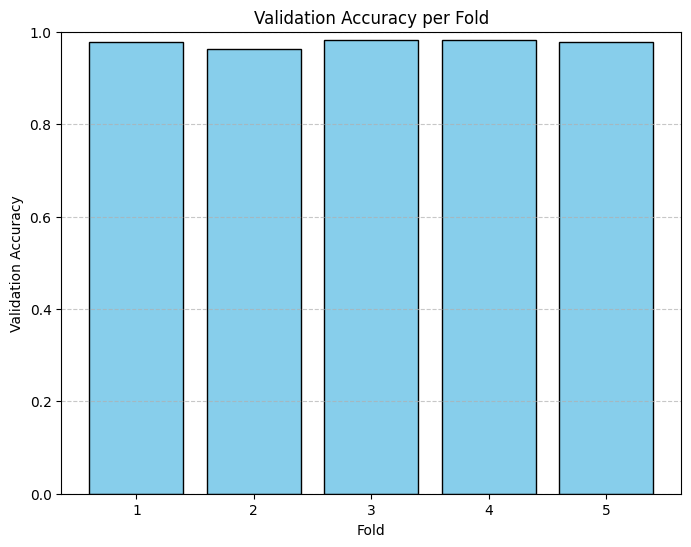

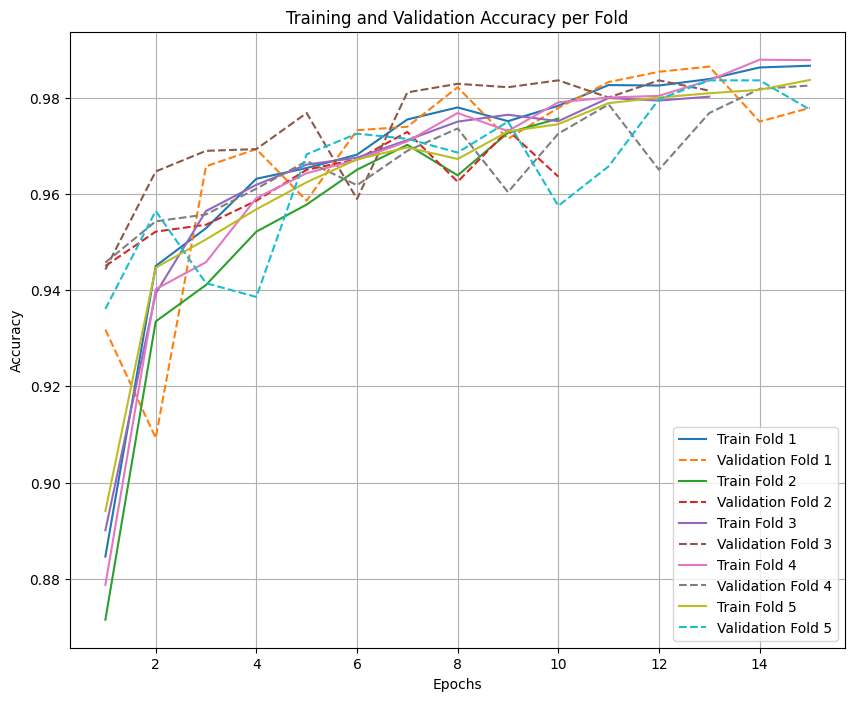

In [26]:
# Description: Plot validation accuracy per fold and training vs. validation accuracy over epochs.
import matplotlib.pyplot as plt

# Evaluate and visualize performance across the k-folds
fold_indices = list(range(1, N_SPLITS+1))  # e.g., [1, 2, 3, 4, 5]

plt.figure(figsize=(8,6))
plt.bar(fold_indices, val_scores, color='skyblue', edgecolor='black')
plt.title("Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy")
plt.xticks(fold_indices)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Additionally, visualize training and validation accuracy curves for each fold
plt.figure(figsize=(10,8))
for i, hist in enumerate(histories):
    epochs = range(1, len(hist.history['accuracy']) + 1)
    plt.plot(epochs, hist.history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(epochs, hist.history['val_accuracy'], label=f'Validation Fold {i+1}', linestyle='--')
plt.title("Training and Validation Accuracy per Fold")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

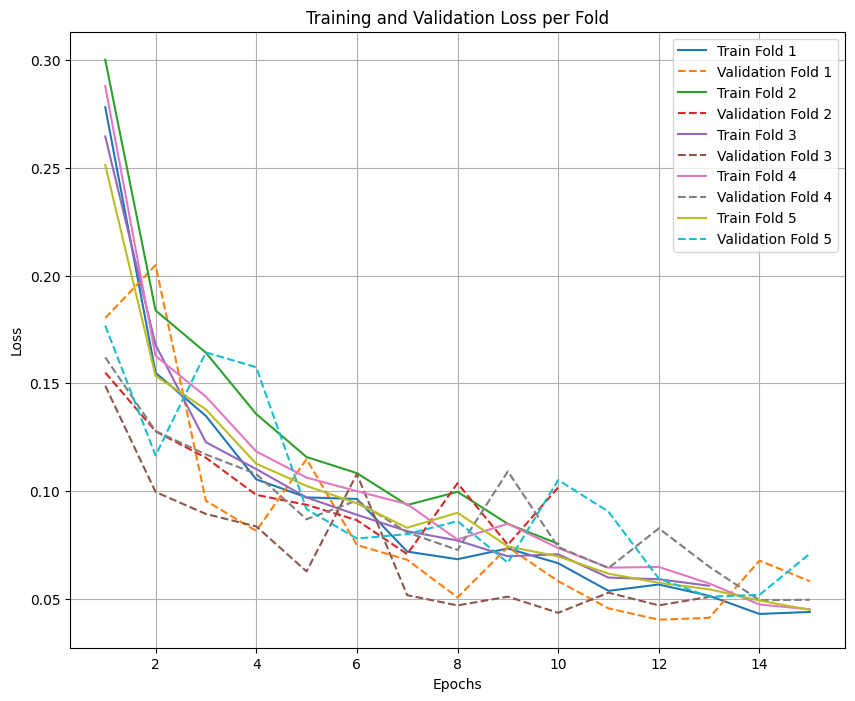

In [27]:
# Description: Visualize training and validation loss curves across folds.
plt.figure(figsize=(10,8))
for i, hist in enumerate(histories):
    epochs = range(1, len(hist.history['loss']) + 1)
    plt.plot(epochs, hist.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(epochs, hist.history['val_loss'], label=f'Validation Fold {i+1}', linestyle='--')
plt.title("Training and Validation Loss per Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Description: Calculate and print additional performance metrics including precision, recall, F1-score, AUC, and confusion matrix.
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Evaluate additional metrics on the hold-out test set
# Assume true labels are available from the generator (holdout_gen.classes)
y_true = holdout_gen.classes
y_pred_prob = model.predict(holdout_gen).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
cm = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Precision: 0.9816
Recall: 0.9924
F1-score: 0.9869
AUC-ROC: 0.9980
Confusion Matrix:
[[ 824   49]
 [  20 2607]]
Precision: 0.9816
Recall: 0.9924
F1-score: 0.9869
AUC-ROC: 0.9980
Confusion Matrix:
[[ 824   49]
 [  20 2607]]
